In [1]:
import os
import sys
import datetime 
import numpy as np
import math
sys.path.append("..")
# from tqdm.rich import tqdm, trange
from tqdm import tqdm, trange
from copy import deepcopy
import h5py
import pandas as pd 

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import seaborn as sns
import matplotlib.pylab as plt

from data import get_database_path, get_h5_files, read_h5_file, select_events



In [2]:
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Set default tensor type
if sys.platform == "darwin":
    # Mac OS
    default_precision = torch.float32
else:
    # Linux or Windows
    default_precision = torch.float64
torch.set_default_dtype(default_precision)

# Set device
#device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
print(f"Using {device} device")

Using cuda device


# Load dataset

In [88]:
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()


# SM processes
particle_type_scale = 10
bkg = read_h5_file(database_path, bkg_files[0]['file'])
emb_path = os.path.join("..","generated_data")
bkg_pairs, bkg_emds = read_h5_file(emb_path, "bkg_emds_type_scale{}.h5".format(particle_type_scale), datatype='EMD')


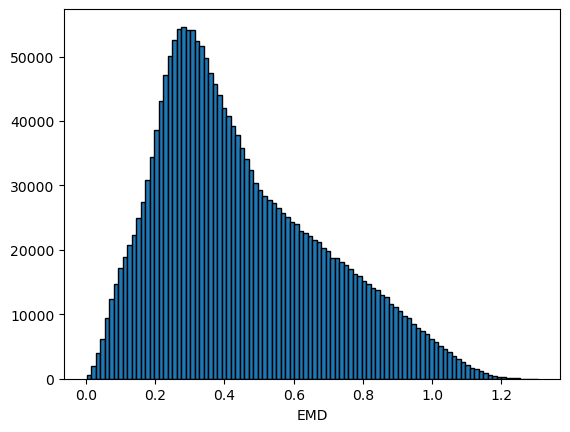

In [89]:
plt.hist(bkg_emds, bins=100,edgecolor='black')
plt.xlabel("EMD")
plt.show()

In [90]:
from data import PairedEventsDataset, RealTimeEMDDataset

In [91]:
print(len(bkg), len(bkg_pairs), len(bkg_emds))
train_val_split = 0.8
train_size = int(len(bkg_pairs) * train_val_split)
print(train_size)

13451915 2000000 2000000
1600000


In [92]:
train_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[:train_size], bkg_emds[:train_size])
val_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[train_size:], bkg_emds[train_size:])

In [93]:
selected_train = 1000000
selected_val = 100000
train_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[:selected_train], bkg_emds[:selected_train])
val_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[-selected_val:], bkg_emds[-selected_val:])
print(len(train_bkg_dataset), len(val_bkg_dataset))

1000000 100000


In [94]:
train_bkg_dataloader = DataLoader(train_bkg_dataset, batch_size=256, shuffle=True, num_workers=8, prefetch_factor=32, pin_memory=True)
val_bkg_dataloader = DataLoader(val_bkg_dataset, batch_size=256, pin_memory=True)

# Model

In [95]:
from model import ParticleEventTransformer, particleTransformer

# Loss & Metric

In [96]:
from torchmetrics.regression import MeanAbsolutePercentageError
from metrics import MetricUpdater, MAPE_dispersion, embed_ratio

MAPE = MeanAbsolutePercentageError().to(device)
MAPE_updater = MetricUpdater(MAPE)
MAPE_dispersion_updater = MetricUpdater(MAPE_dispersion)
embed_ratio_updater = MetricUpdater(embed_ratio)


In [97]:
metric_dict = {"MAPE": MAPE_updater, "MAPE on index of dispersion": MAPE_dispersion_updater, "Embed Ratio": embed_ratio_updater}

# Train Pipeline

In [98]:
from train import train_model

# Train!

In [99]:
feature_size = 3  # pT, eta, phi
embed_size = 16  # Dimension of embedding space
num_heads = 8    # Number of attention heads
num_layers = 4   # Number of nn.TransformerEncoderLayer
hidden_dim = 256 # Dimension of the feedforward network model in nn.TransformerEncoder
output_dim = 2  # Final dimension of the output embedding


model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)
# model = particleTransformer(feature_size, d_model=embed_size, nhead=num_heads, num_encoder_layers=num_layers, embed_dim=output_dim, max_seq_length=19, pos_dropout=0.1, layer_widths=[200,50,10])

model.to(device)
def loss_function(embed_dist, emd):
    # return MAPE(embed_dist, emd)
    return MAPE(embed_dist, emd) + torch.var(embed_dist / emd)
from metrics import Euclidean_distance, hyperbolic_distance
dist_fn = Euclidean_distance
# dist_fn = hyperbolic_distance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = None

/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [100]:
opt_train_model = torch.compile(train_model)

In [101]:
dfhistory = opt_train_model(model, optimizer, 
                        loss_function, dist_fn, metric_dict, 
                        train_dataloader=train_bkg_dataloader, val_dataloader=val_bkg_dataloader,
                        scheduler=scheduler,
                        monitor="val_MAPE", mode="min",
                        epochs=50)


================================================================================2024-05-04 21:29:26
Epoch 1 / 50

  0%|          | 0/391 [00:00<?, ?it/s]

[2024-05-04 21:32:05,080] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2024-05-04 21:32:05,080] torch._dynamo.convert_frame: [WARNING]    function: 'step' (/home/desmondhe/ADwithNE/demo/../train.py:30)
[2024-05-04 21:32:05,080] torch._dynamo.convert_frame: [WARNING]    last reason: ___check_global_state()
[2024-05-04 21:32:05,080] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2024-05-04 21:32:05,080] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.


100%|██████████| 391/391 [00:16<00:00, 23.23it/s, val_Embed Ratio=1.29, val_MAPE=0.327, val_MAPE on index of dispersion=0.113, val_loss=0.192] 
<<<<<< reach best val_MAPE : 0.32715497369568025 >>>>>>

================================================================================2024-05-04 21:32:21
Epoch 2 / 50

100%|██████████| 391/391 [00:05<00:00, 76.08it/s, val_Embed Ratio=1.25, val_MAPE=0.29, val_MAPE on index of dispersion=0.14, val_loss=0.173]   
<<<<<< reach best val_MAPE : 0.2898522671781929 >>>>>>

================================================================================2024-05-04 21:34:53
Epoch 3 / 50

100%|██████████| 391/391 [00:05<00:00, 76.63it/s, val_Embed Ratio=1.17, val_MAPE=0.232, val_MAPE on index of dispersion=0.156, val_loss=0.162] 
<<<<<< reach best val_MAPE : 0.23204029630025844 >>>>>>

================================================================================2024-05-04 21:37:13
Epoch 4 / 50

100%|██████████| 391/391 [00:05<00:00, 76.56it/s, val_Em

In [102]:
from visualize import plot_train_history

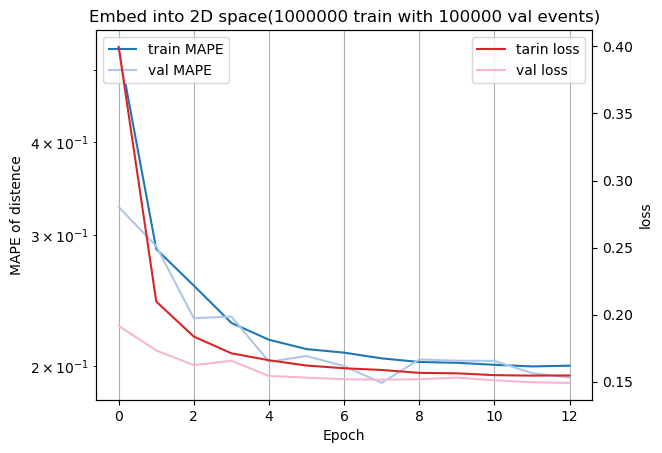

In [103]:
plot_train_history(dfhistory, "Embed into {}D space({} train with {} val events)".format(output_dim, len(train_bkg_dataset), len(val_bkg_dataset)))

In [104]:
from analysis import inference

In [105]:
from data import EventDataset

In [106]:
infer_test_num = 100000
bkg_infer_test = bkg[:infer_test_num]
infer_dataset = EventDataset(bkg_infer_test)
infer_dataloader = DataLoader(infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

In [107]:
model.load_state_dict(torch.load("checkpoint.pt"))
embed_points = inference(model, infer_dataloader, embed_dim=output_dim)

  0%|          | 0/391 [00:00<?, ?it/s]

100%|██████████| 391/391 [00:05<00:00, 66.60it/s] 


In [108]:
from utils import embed_dict

In [109]:
only_electron_index = select_events(bkg_infer_test, [1,0,0])
only_muon_index = select_events(bkg_infer_test, [0,1,0])
electron_muon_index = select_events(bkg_infer_test, [1,1,0])
electron_with_jets_index = select_events(bkg_infer_test, [1,0,1])
muon_with_jets_index = select_events(bkg_infer_test, [0,1,1])
e_mu_jets_index = select_events(bkg_infer_test, [1,1,1])


only_eletron_embed = embed_points[only_electron_index]
print("{} events with only electron".format(len(only_eletron_embed)))
only_muon_embed = embed_points[only_muon_index]
print("{} events with only muon".format(len(only_muon_embed)))
electron_muon_embed = embed_points[electron_muon_index]
print("{} events with electron and muon".format(len(electron_muon_embed)))
electron_with_jets_embed = embed_points[electron_with_jets_index]
print("{} events with electron and jets".format(len(electron_with_jets_embed)))
muon_with_jets_embed = embed_points[muon_with_jets_index]
print("{} events with muon and jets".format(len(muon_with_jets_embed)))
e_mu_jets_embed = embed_points[e_mu_jets_index]
print("{} events with electron, muon and jets".format(len(e_mu_jets_embed)))

only_electron_dict = embed_dict(only_eletron_embed, "Electron")
only_muon_dict = embed_dict(only_muon_embed, "Muon")
electron_muon_dict = embed_dict(electron_muon_embed, "Electron and Muon")
electron_with_jets_dict = embed_dict(electron_with_jets_embed, "Electron with Jets")
muon_with_jets_dict = embed_dict(muon_with_jets_embed, "Muon with Jets")
e_mu_jets_dict = embed_dict(e_mu_jets_embed, "Electron and Muon with Jets")

only_electron_df = pd.DataFrame(only_electron_dict)
only_muon_df = pd.DataFrame(only_muon_dict)
electron_muon_df = pd.DataFrame(electron_muon_dict)
electron_with_jets_df = pd.DataFrame(electron_with_jets_dict)
muon_with_jets_df = pd.DataFrame(muon_with_jets_dict)
e_mu_jets_df = pd.DataFrame(e_mu_jets_dict)

full_df = pd.concat([only_electron_df, only_muon_df, electron_muon_df, electron_with_jets_df, muon_with_jets_df, e_mu_jets_df])




20587 events with only electron
17024 events with only muon
46 events with electron and muon
31667 events with electron and jets
28462 events with muon and jets
2214 events with electron, muon and jets


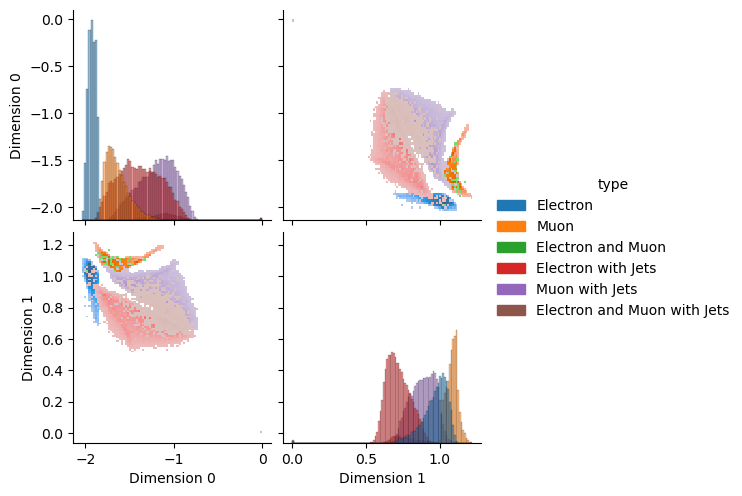

In [110]:
sns.pairplot(full_df, hue="type", kind="hist")
plt.show()

100%|██████████| 219/219 [00:04<00:00, 45.69it/s] 


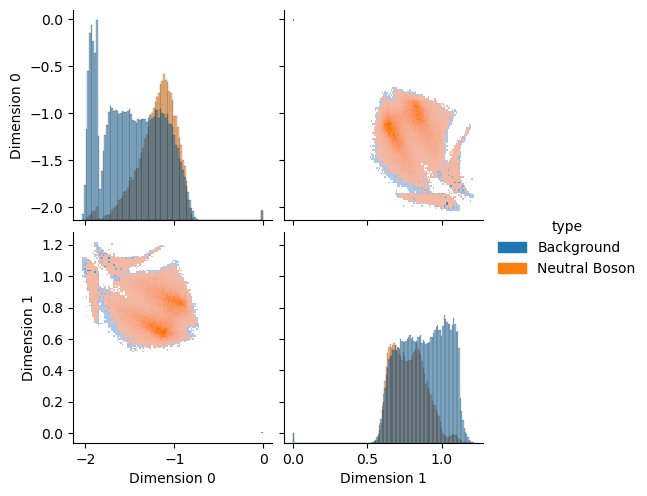

In [111]:
neutral_boson = read_h5_file(database_path, sig_files[0]['file'])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

neutral_boson_dataset = EventDataset(neutral_boson)
neutral_boson_dataloader = DataLoader(neutral_boson_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

neutral_boson_embed_points = inference(model, neutral_boson_dataloader, embed_dim=output_dim)

bkg_dict = embed_dict(embed_points, "Background")
neutral_boson_dict = embed_dict(neutral_boson_embed_points, "Neutral Boson")

bkg_df = pd.DataFrame(bkg_dict)
neutral_boson_df = pd.DataFrame(neutral_boson_dict)

full_df = pd.concat([bkg_df, neutral_boson_df])

sns.pairplot(full_df, hue="type", kind="hist")
plt.show()

100%|██████████| 1331/1331 [00:12<00:00, 110.08it/s]


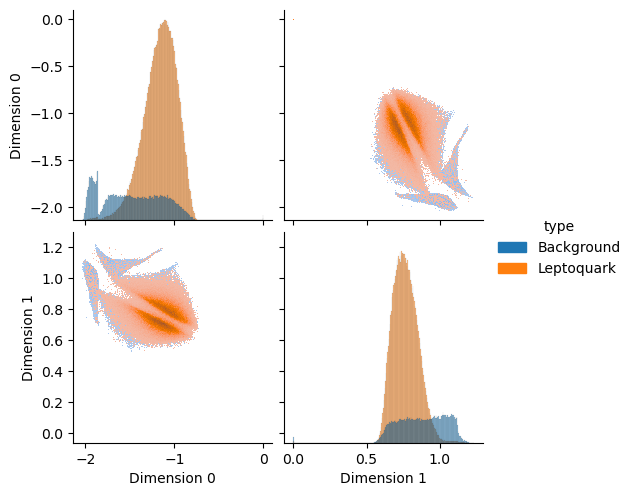

In [112]:
leptoquark = read_h5_file(database_path, sig_files[1]['file'])
# A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

leptoquark_dataset = EventDataset(leptoquark)
leptoquark_dataloader = DataLoader(leptoquark_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

leptoquark_embed_points = inference(model, leptoquark_dataloader, embed_dim=output_dim)

leptoquark_dict = embed_dict(leptoquark_embed_points, "Leptoquark")
leptoquark_df = pd.DataFrame(leptoquark_dict)

full_df = pd.concat([bkg_df, leptoquark_df])

sns.pairplot(full_df, hue="type", kind="hist")
plt.show()

100%|██████████| 2701/2701 [00:21<00:00, 126.60it/s]


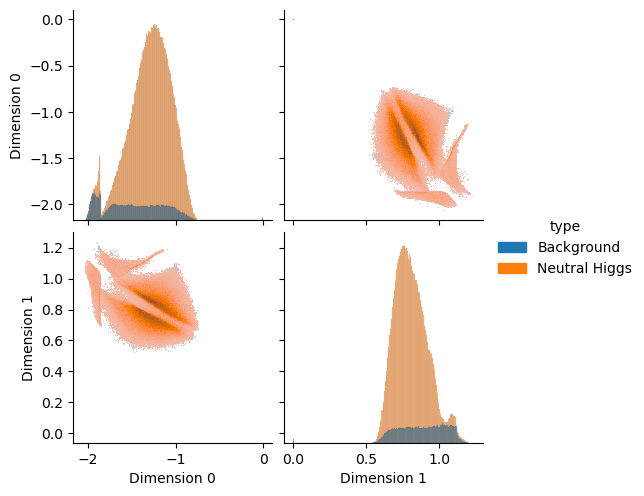

In [113]:
neutral_higgs = read_h5_file(database_path, sig_files[2]['file'])
# A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

neutral_higgs_dataset = EventDataset(neutral_higgs)
neutral_higgs_dataloader = DataLoader(neutral_higgs_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

neutral_higgs_embed_points = inference(model, neutral_higgs_dataloader, embed_dim=output_dim)

neutral_higgs_dict = embed_dict(neutral_higgs_embed_points, "Neutral Higgs")
neutral_higgs_df = pd.DataFrame(neutral_higgs_dict)

full_df = pd.concat([bkg_df, neutral_higgs_df])

sns.pairplot(full_df, hue="type", kind="hist")
plt.show()

100%|██████████| 2970/2970 [00:23<00:00, 128.43it/s]


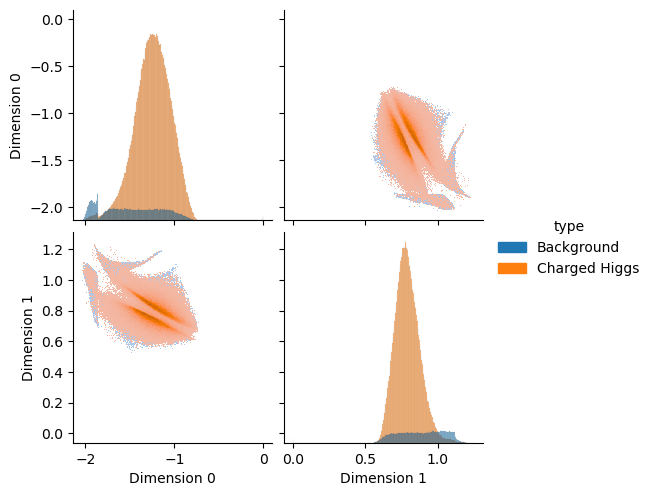

In [114]:
charged_higgs = read_h5_file(database_path, sig_files[3]['file'])
# A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino

charged_higgs_dataset = EventDataset(charged_higgs)
charged_higgs_dataloader = DataLoader(charged_higgs_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

charged_higgs_embed_points = inference(model, charged_higgs_dataloader, embed_dim=output_dim)

charged_higgs_dict = embed_dict(charged_higgs_embed_points, "Charged Higgs")
charged_higgs_df = pd.DataFrame(charged_higgs_dict)

full_df = pd.concat([bkg_df, charged_higgs_df])

sns.pairplot(full_df, hue="type", kind="hist")
plt.show()


In [115]:
torch.save(model.state_dict(), os.path.join("..", "model","emb_dim{}_type_scale{}.pt".format(output_dim, particle_type_scale)))

: 

In [37]:
%load_ext autoreload
%autoreload 1
%aimport visualize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
